# ITI110 Project : Energy Consumption Forecasting

## Data Preprocessing for Hourly Energy Consumption Dataset (Carel)

In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import math
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D
from matplotlib import pyplot as plt
import keras
# !pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow as tf

In [2]:
training_session_folder = 'C:/Users/chiny/cjwen/ITI110/hourly_training'

### Load Data For Hourly Dataset

In [49]:
df = pd.read_csv("2.2 merged_aggregated_hourly_without_block_id.csv")

# folder_path = r'C:\Users\Carel\Documents\Course NYP Specialist Diploma in Applied AI PDC2\SDAAI PDC2\ITI110 Project\code file\WIP project'
# csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# os.listdir(folder_path)


In [50]:
# !pip install dask

In [51]:
# !pip show pyarrow

In [52]:
df.head()

,date,month,hour,count_LCLid,count_block_id,sum_energy_by_hour,tstp,avg_energy_per_lclid,holiday,visibility,...,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,2011-11-23,11,9,2,2,1.130,2011-11-23 09:00:00,0.565000,0.0,4.39,...,4.84,2011-11-23 09:00:00,4.68,1027.29,3.42,1.78,rain,partly-cloudy-day,0.99,Partly Cloudy
1,2011-11-23,11,10,6,4,1.508,2011-11-23 10:00:00,0.251333,0.0,6.24,...,5.74,2011-11-23 10:00:00,5.46,1027.67,4.24,1.99,rain,partly-cloudy-day,0.98,Partly Cloudy
2,2011-11-23,11,11,7,5,2.123,2011-11-23 11:00:00,0.303286,0.0,10.20,...,7.67,2011-11-23 11:00:00,5.74,1027.56,5.94,2.66,rain,partly-cloudy-day,0.88,Partly Cloudy
3,2011-11-23,11,12,10,7,6.589,2011-11-23 12:00:00,0.658900,0.0,11.62,...,8.84,2011-11-23 12:00:00,6.52,1027.24,7.25,2.80,rain,partly-cloudy-day,0.85,Partly Cloudy
4,2011-11-23,11,13,13,9,6.263,2011-11-23 13:00:00,0.481769,0.0,12.68,...,9.87,2011-11-23 13:00:00,6.99,1027.35,8.29,3.12,rain,partly-cloudy-day,0.82,Mostly Cloudy


In [53]:
type(df)

pandas.core.frame.DataFrame

In [54]:
df.columns

Index(['date', 'month', 'hour', 'count_LCLid', 'count_block_id',
       'sum_energy_by_hour', 'tstp', 'avg_energy_per_lclid', 'holiday',
       'visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
      dtype='object')

In [55]:
# Initial Overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19864 entries, 0 to 19863
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  19864 non-null  object 
 1   month                 19864 non-null  int64  
 2   hour                  19864 non-null  int64  
 3   count_LCLid           19864 non-null  int64  
 4   count_block_id        19864 non-null  int64  
 5   sum_energy_by_hour    19864 non-null  float64
 6   tstp                  19864 non-null  object 
 7   avg_energy_per_lclid  19864 non-null  float64
 8   holiday               19864 non-null  float64
 9   visibility            19862 non-null  float64
 10  windBearing           19862 non-null  float64
 11  temperature           19862 non-null  float64
 12  time                  19862 non-null  object 
 13  dewPoint              19862 non-null  float64
 14  pressure              19851 non-null  float64
 15  apparentTemperature

In [56]:
# Compute missing values to view actual missing value count for each column
df.isnull().sum()      

date                     0
month                    0
hour                     0
count_LCLid              0
count_block_id           0
sum_energy_by_hour       0
tstp                     0
avg_energy_per_lclid     0
holiday                  0
visibility               2
windBearing              2
temperature              2
time                     2
dewPoint                 2
pressure                13
apparentTemperature      2
windSpeed                2
precipType               2
icon                     2
humidity                 2
summary                  2
dtype: int64

#### Drop the category columns

In [57]:
df = df.drop(['precipType', 'icon', 'summary'], axis=1)

In [58]:
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df['tstp'] = pd.to_datetime(df['tstp'])


In [59]:
import pandas as pd

# Create a new DataFrame with just the 'date', 'tstp' and 'time'  columns
date_tstp_time_df = df[['date', 'tstp', 'time']]

# Display the new DataFrame
print(date_tstp_time_df)

            date                tstp                time
0     2011-11-23 2011-11-23 09:00:00 2011-11-23 09:00:00
1     2011-11-23 2011-11-23 10:00:00 2011-11-23 10:00:00
2     2011-11-23 2011-11-23 11:00:00 2011-11-23 11:00:00
3     2011-11-23 2011-11-23 12:00:00 2011-11-23 12:00:00
4     2011-11-23 2011-11-23 13:00:00 2011-11-23 13:00:00
...          ...                 ...                 ...
19859 2014-02-27 2014-02-27 20:00:00 2014-02-27 20:00:00
19860 2014-02-27 2014-02-27 21:00:00 2014-02-27 21:00:00
19861 2014-02-27 2014-02-27 22:00:00 2014-02-27 22:00:00
19862 2014-02-27 2014-02-27 23:00:00 2014-02-27 23:00:00
19863 2014-02-28 2014-02-28 00:00:00 2014-02-28 00:00:00

[19864 rows x 3 columns]


In [60]:
# Check if the 'date' and 'time' columns are the same
are_same = (df['tstp'] == df['time']).all()

if are_same:
    print("The 'tstp' and 'time' columns have the same values.")
else:
    print("The 'tstp' and 'time' columns have different values.")


The 'tstp' and 'time' columns have different values.


#### Filter to tstp and time columns to see where the non-matches lie

In [61]:
import pandas as pd

# Filter rows where 'tstp' and 'time' differ
filtered_df = df[df['tstp'] != df['time']]

# Display the differences
filtered_df[['date', 'tstp', 'time']]


,date,tstp,time
15758,2013-09-09,2013-09-09 23:00:00,NaT
15759,2013-09-10,2013-09-10 00:00:00,NaT


#### Notes: Since 'time' column is exact match with 'tstp' column, except for 2 rows: 15758 and 15759. It will not make sense to inpute the dates in these rows, therefore we will drop these rows.

In [62]:
# Drop specific rows from the DataFrame
df = df.drop([15758, 15759])

In [63]:
df.isnull().sum()

date                     0
month                    0
hour                     0
count_LCLid              0
count_block_id           0
sum_energy_by_hour       0
tstp                     0
avg_energy_per_lclid     0
holiday                  0
visibility               0
windBearing              0
temperature              0
time                     0
dewPoint                 0
pressure                11
apparentTemperature      0
windSpeed                0
humidity                 0
dtype: int64

#### Identify the missing data from pressure column

In [64]:
missing_pressure = df['pressure'].isnull()

df_missing_pressure = df[missing_pressure]
df_missing_pressure

,date,month,hour,count_LCLid,count_block_id,sum_energy_by_hour,tstp,avg_energy_per_lclid,holiday,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,humidity
3993,2012-05-07,5,18,2348,112,1392.479999,2012-05-07 18:00:00,0.593049,0.0,11.27,189.0,12.99,2012-05-07 18:00:00,8.29,NaN,12.99,4.22,0.73
8118,2012-10-26,10,15,5494,112,2668.932000,2012-10-26 15:00:00,0.485790,0.0,11.27,21.0,7.29,2012-10-26 15:00:00,3.68,NaN,4.21,4.99,0.78
9766,2013-01-03,1,7,5486,112,1993.104000,2013-01-03 07:00:00,0.363307,0.0,9.66,250.0,9.65,2013-01-03 07:00:00,8.67,NaN,7.07,5.21,0.94
13540,2013-06-09,6,13,5319,112,2377.313000,2013-06-09 13:00:00,0.446947,0.0,9.98,48.0,13.42,2013-06-09 13:00:00,7.76,NaN,13.42,5.07,0.69
14799,2013-08-01,8,0,5268,112,1410.029000,2013-08-01 00:00:00,0.267659,0.0,9.98,193.0,19.16,2013-08-01 00:00:00,16.78,NaN,19.38,2.80,0.86
15160,2013-08-16,8,1,5241,112,1152.973000,2013-08-16 01:00:00,0.219991,0.0,9.98,217.0,17.01,2013-08-16 01:00:00,14.84,NaN,17.04,3.83,0.87
15398,2013-08-25,8,23,5221,112,1573.785000,2013-08-25 23:00:00,0.301434,0.0,6.39,10.0,17.56,2013-08-25 23:00:00,15.49,NaN,17.66,3.75,0.88
15399,2013-08-26,8,0,5227,112,1391.607001,2013-08-26 00:00:00,0.266234,1.0,4.39,358.0,17.02,2013-08-26 00:00:00,15.42,NaN,17.13,2.72,0.90
15736,2013-09-09,9,1,5216,112,1095.127000,2013-09-09 01:00:00,0.209955,0.0,9.51,221.0,9.39,2013-09-09 01:00:00,8.03,NaN,8.03,2.61,0.91
15739,2013-09-09,9,4,5216,112,1014.337000,2013-09-09 04:00:00,0.194466,0.0,9.46,224.0,9.99,2013-09-09 04:00:00,7.72,NaN,9.64,1.51,0.86


In [65]:
df['pressure'] = df['pressure'].fillna(df['pressure'].mean())

# check that it's been filled
# df.isnull().sum()

In [66]:
# # save updated dataset if desired
# data = df.to_csv('2.2 merged_aggregated_hourly_without_block_id_prepd.csv')

In [67]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

In [68]:
# df[['temperature', 'humidity', 'windSpeed']]=scaler.fit_transform(df[['temperature', 'humidity', 'windSpeed']])

In [69]:
# df[['temperature', 'humidity', 'windSpeed']]

### Splitting the data to prepare for training

In [70]:
import pandas as pd

train_rows = int(0.8*len(df))

train = df[:train_rows]
test = df[train_rows:]

# Check rows
print("dataset no. of rows: ", len(df))
print("train dataset no. of rows: ", len(train))
print("test dataset no. of rows: ", len(test))


# parameters for training subject to change depending on experiment plans
x_train = train[['temperature', 'humidity', 'windSpeed', 'holiday','month','hour']]
y_train = train[['avg_energy_per_lclid']]

x_test = test[['temperature', 'humidity', 'windSpeed', 'holiday','month','hour']]
y_test = test[['avg_energy_per_lclid']]

dataset no. of rows:  19862
train dataset no. of rows:  15889
test dataset no. of rows:  3973


### Normalization / Scaling of data

#### Notes: Normalizing and scaling will depend on the model chosen

In [71]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform the training and test data
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.transform(x_test)

# Now x_train_normalized and x_test_normalized contain the normalized values of the respective features


In [72]:
# View the normalized data

print("Normalized x_train data:")
print(x_train_normalized[:10])

print("Normalized x_test data:")
print(x_test_normalized[:10])


Normalized x_train data:
[[0.27549947 0.98701299 0.13043478 0.         0.90909091 0.39130435]
 [0.29915878 0.97402597 0.14617691 0.         0.90909091 0.43478261]
 [0.34989485 0.84415584 0.1964018  0.         0.90909091 0.47826087]
 [0.38065195 0.80519481 0.20689655 0.         0.90909091 0.52173913]
 [0.40772871 0.76623377 0.23088456 0.         0.90909091 0.56521739]
 [0.42060988 0.79220779 0.24137931 0.         0.90909091 0.60869565]
 [0.41351209 0.80519481 0.22488756 0.         0.90909091 0.65217391]
 [0.40694006 0.81818182 0.21814093 0.         0.90909091 0.69565217]
 [0.38853838 0.8961039  0.1904048  0.         0.90909091 0.73913043]
 [0.38801262 0.87012987 0.21514243 0.         0.90909091 0.7826087 ]]
Normalized x_test data:
[[0.51025237 0.58441558 0.53898051 0.         0.72727273 0.52173913]
 [0.52260778 0.62337662 0.57946027 0.         0.72727273 0.56521739]
 [0.51840168 0.76623377 0.55247376 0.         0.72727273 0.60869565]
 [0.51182965 0.84415584 0.60044978 0.         0.72727

In [73]:
x_train.to_csv("x_train_hourly.csv")
x_test.to_csv("x_test_hourly.csv")
y_train.to_csv("y_train_hourly.csv")
y_test.to_csv("y_test_hourly.csv")

# Train

In [3]:
x_train = pd.read_csv("hourly_training/x_train_hourly.csv")
x_test = pd.read_csv("hourly_training/x_test_hourly.csv")
y_train = pd.read_csv("hourly_training/y_train_hourly.csv")
y_test = pd.read_csv("hourly_training/y_test_hourly.csv")


In [4]:
x_train.drop(columns = "Unnamed: 0", axis = 1, inplace=True)
x_test.drop(columns = "Unnamed: 0", axis = 1, inplace=True)
y_train.drop(columns = "Unnamed: 0", axis = 1, inplace=True)
y_test.drop(columns = "Unnamed: 0", axis = 1, inplace=True)

In [5]:
#reshape input to be 3D
x_train = x_train.to_numpy().reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.to_numpy().reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(15889, 1, 6) (15889, 1) (3973, 1, 6) (3973, 1)


In [6]:
def train_performance_visualization(model, input_data, actual, start_row, end_row):
    pred = model.predict(input_data)
    run_mae = mae(actual,pred)
    run_mape = mape(actual,pred)
    run_rmse = math.sqrt(mean_squared_error(actual,pred))
    print(f"MAE: {run_mae}")
    print(f"MAPE: {run_mape}")
    print(f"RMSE: {run_rmse}")
    plt.plot(actual.reset_index(drop=True)[start_row:end_row], label='actual')
    plt.plot(pred[start_row:end_row], label='prediction')
    plt.title("Actual vs prediction")
    plt.legend()
    plt.show()

# Run 1



Epoch 1/500

221/221 - 3s - loss: 0.1464 - mean_absolute_error: 0.1464 - val_loss: 0.1289 - val_mean_absolute_error: 0.1289 - 3s/epoch - 12ms/step
Epoch 2/500
221/221 - 0s - loss: 0.0681 - mean_absolute_error: 0.0681 - val_loss: 0.1247 - val_mean_absolute_error: 0.1247 - 360ms/epoch - 2ms/step
Epoch 3/500
221/221 - 0s - loss: 0.0626 - mean_absolute_error: 0.0626 - val_loss: 0.1082 - val_mean_absolute_error: 0.1082 - 348ms/epoch - 2ms/step
Epoch 4/500
221/221 - 0s - loss: 0.0597 - mean_absolute_error: 0.0597 - val_loss: 0.1076 - val_mean_absolute_error: 0.1076 - 342ms/epoch - 2ms/step
Epoch 5/500
221/221 - 0s - loss: 0.0582 - mean_absolute_error: 0.0582 - val_loss: 0.1018 - val_mean_absolute_error: 0.1018 - 334ms/epoch - 2ms/step
Epoch 6/500
221/221 - 0s - loss: 0.0571 - mean_absolute_error: 0.0571 - val_loss: 0.0898 - val_mean_absolute_error: 0.0898 - 343ms/epoch - 2ms/step
Epoch 7/500
221/221 - 0s - loss: 0.0553 - mean_absolute_error: 0.0553 - val_loss: 0.0845 - val_mean_absolute_er

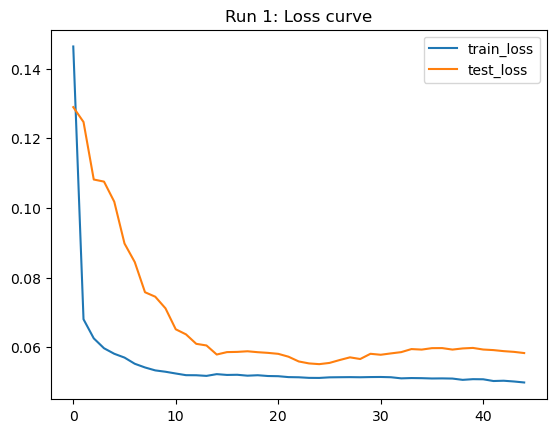

In [32]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/run_1/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.2f}-val_MAE-{val_mean_absolute_error:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
]
# fit network
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=500, batch_size=72, callbacks=callbacks_list, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Run 1: Loss curve")
plt.legend()
plt.show()

125/125 [==============================] - 0s 873us/step
MAE: 0.058359093912705134
MAPE: 0.13702563732361436
RMSE: 0.075409551964566


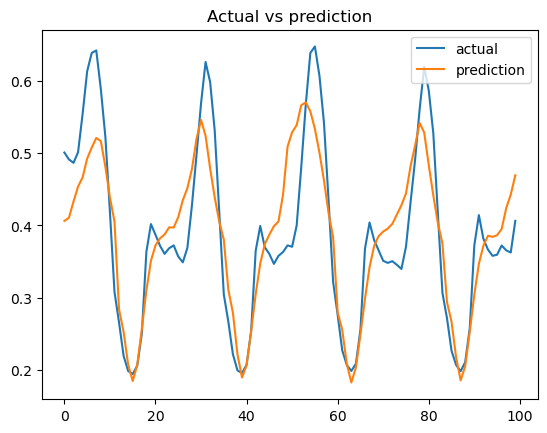

In [36]:
train_performance_visualization(x_test,y_test,0,100)

497/497 [==============================] - 0s 786us/step
MAE: 0.05546546184393876
MAPE: 0.1293382153727308
RMSE: 0.07335931062692028


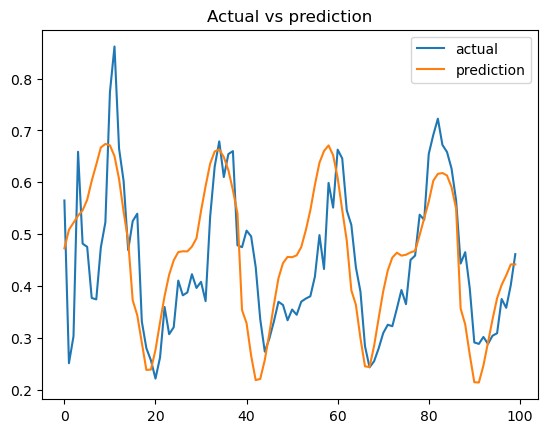

In [37]:
train_performance_visualization(x_train,y_train,0,100)

# Run 2

In [38]:
import keras_tuner as kt

In [39]:
def model_builder(hp):
    model = Sequential()
    
    # Tune the number of units in the first LSTM layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [40]:
tuner=kt.Hyperband(model_builder,
                   objective = 'val_mean_absolute_error', 
                   max_epochs = 50, 
                   factor= 3)

Reloading Tuner from .\untitled_project\tuner0.json


In [42]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_2/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.2f}-val_MAE-{val_mean_absolute_error:4.2f}-loss-{val_loss:4.2f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
    

In [43]:
tuner.search(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)


In [44]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")




The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is 256 and the optimal learning rate for the optimizer
is 0.01.



Epoch 1/500
497/497 [==============================] - 3s 3ms/step - loss: 0.0771 - mean_absolute_error: 0.0771 - val_loss: 0.0615 - val_mean_absolute_error: 0.0615
Epoch 2/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0574 - mean_absolute_error: 0.0574 - val_loss: 0.0677 - val_mean_absolute_error: 0.0677
Epoch 3/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0554 - mean_absolute_error: 0.0554 - val_loss: 0.0666 - val_mean_absolute_error: 0.0666
Epoch 4/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0540 - mean_absolute_error: 0.0540 - val_loss: 0.0594 - val_mean_absolute_error: 0.0594
Epoch 5/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0527 - mean_absolute_error: 0.0527 - val_loss: 0.0574 - val_mean_absolute_error: 0.0574
Epoch 6/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0513 - mean_absolute_error: 0.0513 - val_loss: 0.0610 - val_mean_absolute_error: 0.0610
Epoch 7/50

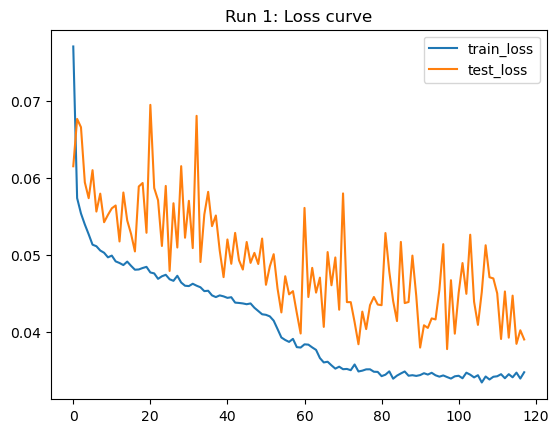

In [45]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Run 1: Loss curve")
plt.legend()
plt.show()

125/125 [==============================] - 0s 962us/step
MAE: 0.03897603451465928
MAPE: 0.09152731568803053
RMSE: 0.05018870824472864


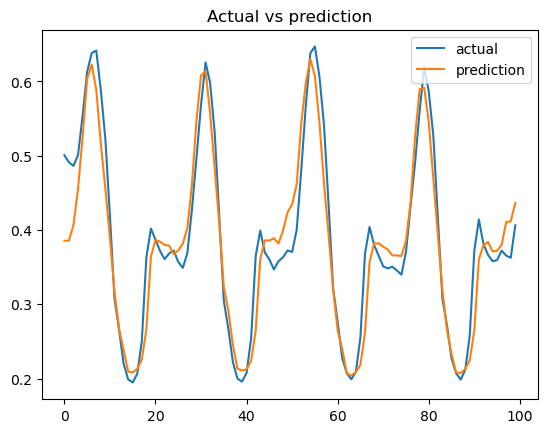

In [47]:
train_performance_visualization(x_test, y_test, 0,100)

497/497 [==============================] - 1s 974us/step
MAE: 0.03168289899796832
MAPE: 0.07248898596060123
RMSE: 0.04457619411167748


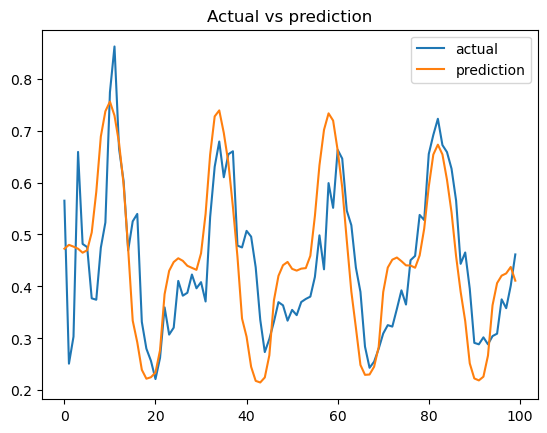

In [80]:
train_performance_visualization(x_train, y_train,0, 100)

In [ ]:
# # fit network
#     history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=500, batch_size=72, callbacks=callbacks_list, verbose=2, shuffle=False)
#     # plot history
#     plt.plot(history.history['loss'], label='train_loss')
#     plt.plot(history.history['val_loss'], label='test_loss')
#     plt.title("Run 1: Loss curve")
#     plt.legend()
#     plt.show()

# Run 3

Epoch 1/500
221/221 - 3s - loss: 0.0985 - mean_absolute_error: 0.0985 - val_loss: 0.1025 - val_mean_absolute_error: 0.1025 - 3s/epoch - 15ms/step
Epoch 2/500
221/221 - 0s - loss: 0.0638 - mean_absolute_error: 0.0638 - val_loss: 0.0993 - val_mean_absolute_error: 0.0993 - 489ms/epoch - 2ms/step
Epoch 3/500
221/221 - 0s - loss: 0.0607 - mean_absolute_error: 0.0607 - val_loss: 0.0958 - val_mean_absolute_error: 0.0958 - 479ms/epoch - 2ms/step
Epoch 4/500
221/221 - 1s - loss: 0.0596 - mean_absolute_error: 0.0596 - val_loss: 0.0924 - val_mean_absolute_error: 0.0924 - 515ms/epoch - 2ms/step
Epoch 5/500
221/221 - 0s - loss: 0.0587 - mean_absolute_error: 0.0587 - val_loss: 0.0913 - val_mean_absolute_error: 0.0913 - 475ms/epoch - 2ms/step
Epoch 6/500
221/221 - 0s - loss: 0.0580 - mean_absolute_error: 0.0580 - val_loss: 0.0906 - val_mean_absolute_error: 0.0906 - 486ms/epoch - 2ms/step
Epoch 7/500
221/221 - 0s - loss: 0.0576 - mean_absolute_error: 0.0576 - val_loss: 0.0879 - val_mean_absolute_error

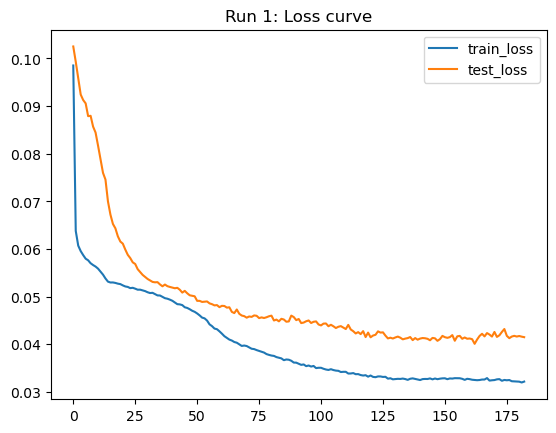

In [92]:
model3 = Sequential()
model3.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model3.add(LSTM(50))
model3.add(Dense(1))
model3.compile(loss='mae', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])


callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/run_3/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.2f}-val_MAE-{val_mean_absolute_error:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
]
# fit network
history = model3.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=500, batch_size=72, callbacks=callbacks_list, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Run 1: Loss curve")
plt.legend()
plt.show()

125/125 [==============================] - 0s 1ms/step
MAE: 0.04148542485752723
MAPE: 0.09496828894542543
RMSE: 0.05309816444063781


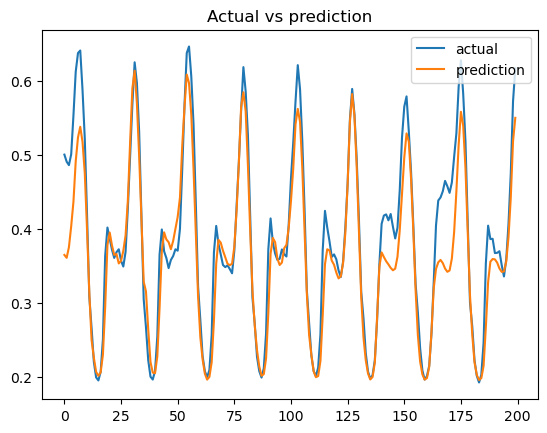

In [102]:
train_performance_visualization(model3, x_test, y_test, 0,200)

497/497 [==============================] - 0s 966us/step
MAE: 0.03992296691674665
MAPE: 0.08826916715336322
RMSE: 0.05455645803182223


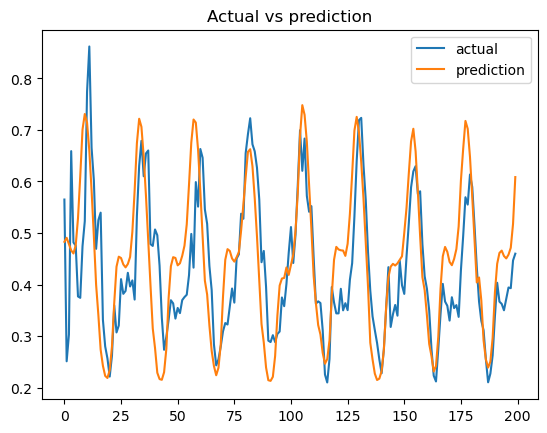

In [101]:
train_performance_visualization(model3, x_train, y_train, 0,200)

# Run 4

In [108]:
def model_builder(hp):
    model = Sequential()
    
    # Tune the number of units in the first LSTM layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units = hp_units))
    model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [110]:
tuner4=kt.Hyperband(model_builder,
                   objective = 'val_mean_absolute_error', 
                   max_epochs = 50, 
                   factor= 3)

In [111]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_4/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
    

In [112]:
tuner4.search(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
# Get the optimal hyperparameters
best_hps=tuner4.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 66 Complete [00h 00m 32s]
val_mean_absolute_error: 0.06504323333501816

Best val_mean_absolute_error So Far: 0.03753520920872688
Total elapsed time: 00h 17m 51s

The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is 96 and the optimal learning rate for the optimizer
is 0.001.



Epoch 1/500
497/497 [==============================] - 4s 4ms/step - loss: 0.0698 - mean_absolute_error: 0.0698 - val_loss: 0.0642 - val_mean_absolute_error: 0.0642
Epoch 2/500
497/497 [==============================] - 1s 2ms/step - loss: 0.0561 - mean_absolute_error: 0.0561 - val_loss: 0.0656 - val_mean_absolute_error: 0.0656
Epoch 3/500
497/497 [==============================] - 1s 2ms/step - loss: 0.0537 - mean_absolute_error: 0.0537 - val_loss: 0.0624 - val_mean_absolute_error: 0.0624
Epoch 4/500
497/497 [==============================] - 1s 2ms/step - loss: 0.0526 - mean_absolute_error: 0.0526 - val_loss: 0.0628 - val_mean_absolute_error: 0.0628
Epoch 5/500
497/497 [==============================] - 1s 2ms/step - loss: 0.0513 - mean_absolute_error: 0.0513 - val_loss: 0.0633 - val_mean_absolute_error: 0.0633
Epoch 6/500
497/497 [==============================] - 1s 2ms/step - loss: 0.0503 - mean_absolute_error: 0.0503 - val_loss: 0.0606 - val_mean_absolute_error: 0.0606
Epoch 7/50

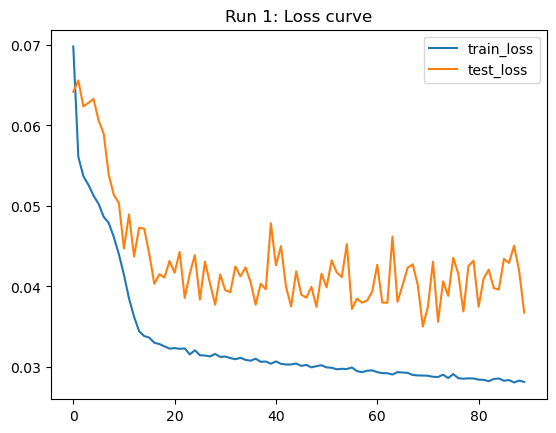

In [113]:
model4 = tuner4.hypermodel.build(best_hps)
history = model4.fit(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Run 1: Loss curve")
plt.legend()
plt.show()

125/125 [==============================] - 0s 1ms/step
MAE: 0.03675275033373564
MAPE: 0.0866950387570169
RMSE: 0.048784333789498854


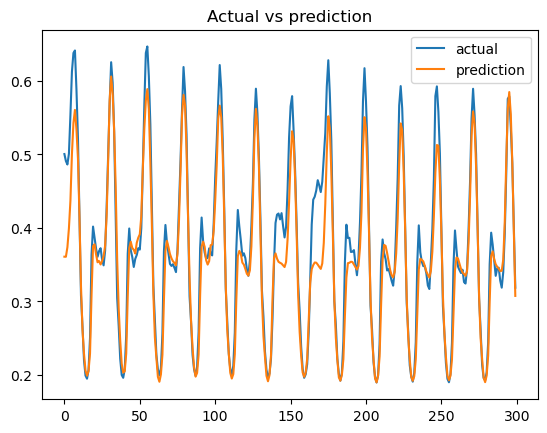

In [126]:
train_performance_visualization(model4, x_test, y_test, 0,300)

497/497 [==============================] - 1s 1ms/step
MAE: 0.028374080056967545
MAPE: 0.06353366626443238
RMSE: 0.04191187065661464


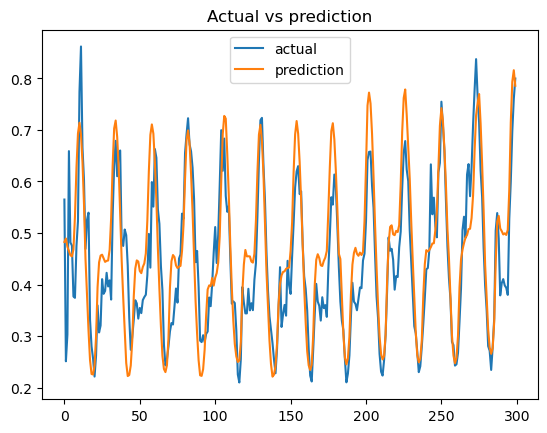

In [127]:
train_performance_visualization(model4, x_train, y_train, 0,300)

# Run 5

Epoch 1/500
221/221 - 5s - loss: 0.1064 - mean_absolute_error: 0.1064 - val_loss: 0.1026 - val_mean_absolute_error: 0.1026 - 5s/epoch - 21ms/step
Epoch 2/500
221/221 - 1s - loss: 0.0631 - mean_absolute_error: 0.0631 - val_loss: 0.1033 - val_mean_absolute_error: 0.1033 - 599ms/epoch - 3ms/step
Epoch 3/500
221/221 - 1s - loss: 0.0595 - mean_absolute_error: 0.0595 - val_loss: 0.1010 - val_mean_absolute_error: 0.1010 - 652ms/epoch - 3ms/step
Epoch 4/500
221/221 - 1s - loss: 0.0591 - mean_absolute_error: 0.0591 - val_loss: 0.0985 - val_mean_absolute_error: 0.0985 - 637ms/epoch - 3ms/step
Epoch 5/500
221/221 - 1s - loss: 0.0587 - mean_absolute_error: 0.0587 - val_loss: 0.0997 - val_mean_absolute_error: 0.0997 - 643ms/epoch - 3ms/step
Epoch 6/500
221/221 - 1s - loss: 0.0579 - mean_absolute_error: 0.0579 - val_loss: 0.0976 - val_mean_absolute_error: 0.0976 - 748ms/epoch - 3ms/step
Epoch 7/500
221/221 - 1s - loss: 0.0572 - mean_absolute_error: 0.0572 - val_loss: 0.0964 - val_mean_absolute_error

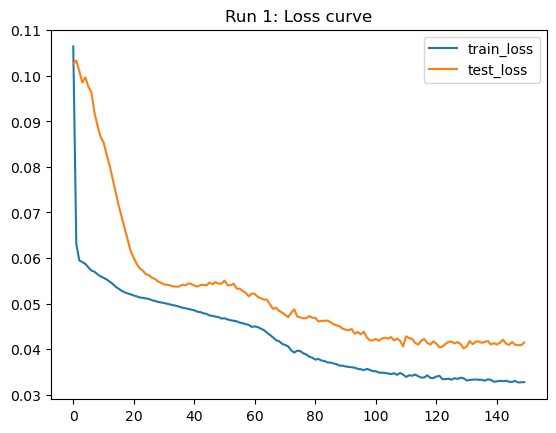

In [128]:
model5 = Sequential()
model5.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model5.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model5.add(LSTM(50))
model5.add(Dense(1))
model5.compile(loss='mae', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])


callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/run_5/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.2f}-val_MAE-{val_mean_absolute_error:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
]
# fit network
history = model5.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=500, batch_size=72, callbacks=callbacks_list, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Run 1: Loss curve")
plt.legend()
plt.show()

125/125 [==============================] - 1s 1ms/step
MAE: 0.04145403060405848
MAPE: 0.09449651728943359
RMSE: 0.05297409768722405


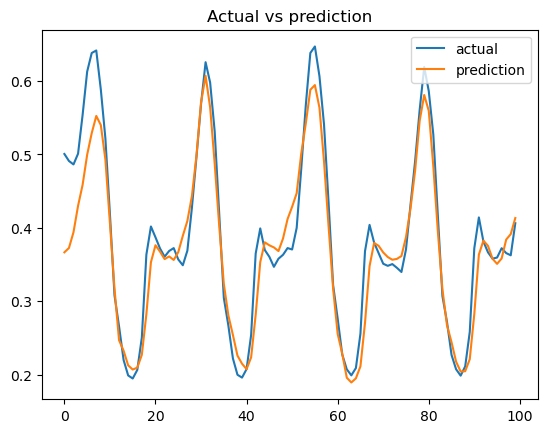

In [129]:
train_performance_visualization(model5, x_test, y_test, 0, 100)

497/497 [==============================] - 1s 1ms/step
MAE: 0.041029071523054406
MAPE: 0.09043227332933153
RMSE: 0.056136774459317584


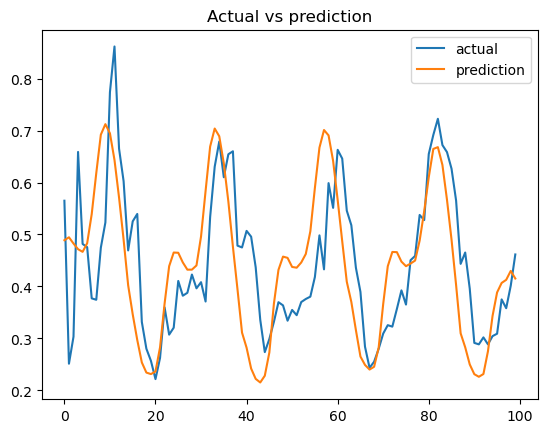

In [130]:
train_performance_visualization(model5, x_train, y_train, 0, 100)

# Run 6

In [131]:
def model_builder(hp):
    model = Sequential()
    
    # Tune the number of units in the first LSTM layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units = hp_units, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units = hp_units))
    model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [132]:
tuner6=kt.Hyperband(model_builder,
                   objective = 'val_mean_absolute_error', 
                   max_epochs = 50, 
                   factor= 3)

In [133]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_6/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.2f}-val_MAE-{val_mean_absolute_error:4.2f}-loss-{val_loss:4.2f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
    

In [134]:
tuner6.search(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
# Get the optimal hyperparameters
best_hps=tuner6.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 63 Complete [00h 00m 26s]
val_mean_absolute_error: 0.06462367624044418

Best val_mean_absolute_error So Far: 0.03518291562795639
Total elapsed time: 00h 25m 07s

The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is 128 and the optimal learning rate for the optimizer
is 0.001.



Epoch 1/500
497/497 [==============================] - 6s 6ms/step - loss: 0.0723 - mean_absolute_error: 0.0723 - val_loss: 0.0630 - val_mean_absolute_error: 0.0630
Epoch 2/500
497/497 [==============================] - 2s 4ms/step - loss: 0.0581 - mean_absolute_error: 0.0581 - val_loss: 0.0667 - val_mean_absolute_error: 0.0667
Epoch 3/500
497/497 [==============================] - 2s 4ms/step - loss: 0.0556 - mean_absolute_error: 0.0556 - val_loss: 0.0640 - val_mean_absolute_error: 0.0640
Epoch 4/500
497/497 [==============================] - 2s 4ms/step - loss: 0.0538 - mean_absolute_error: 0.0538 - val_loss: 0.0604 - val_mean_absolute_error: 0.0604
Epoch 5/500
497/497 [==============================] - 2s 4ms/step - loss: 0.0511 - mean_absolute_error: 0.0511 - val_loss: 0.0608 - val_mean_absolute_error: 0.0608
Epoch 6/500
497/497 [==============================] - 2s 4ms/step - loss: 0.0452 - mean_absolute_error: 0.0452 - val_loss: 0.0578 - val_mean_absolute_error: 0.0578
Epoch 7/50

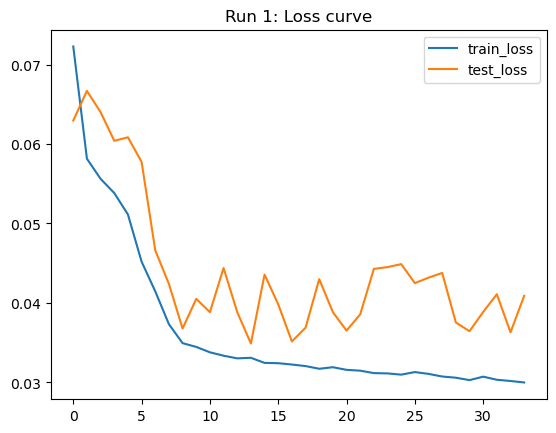

In [135]:
model6 = tuner6.hypermodel.build(best_hps)
history = model6.fit(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Run 1: Loss curve")
plt.legend()
plt.show()

125/125 [==============================] - 1s 1ms/step
MAE: 0.040888594161165935
MAPE: 0.09627517493693022
RMSE: 0.05126515718939221


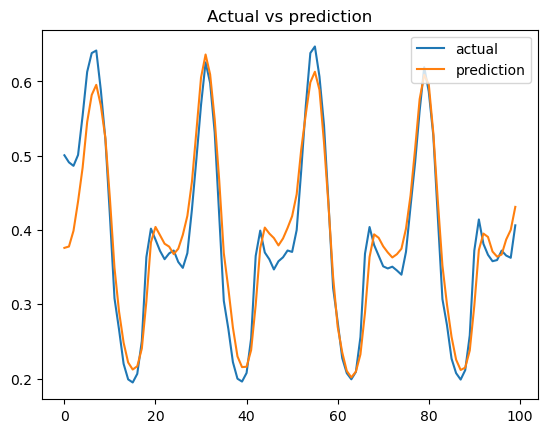

In [136]:
train_performance_visualization(model6, x_test, y_test, 0, 100)

497/497 [==============================] - 1s 1ms/step
MAE: 0.030150794833520365
MAPE: 0.06942634212177368
RMSE: 0.04295718725799931


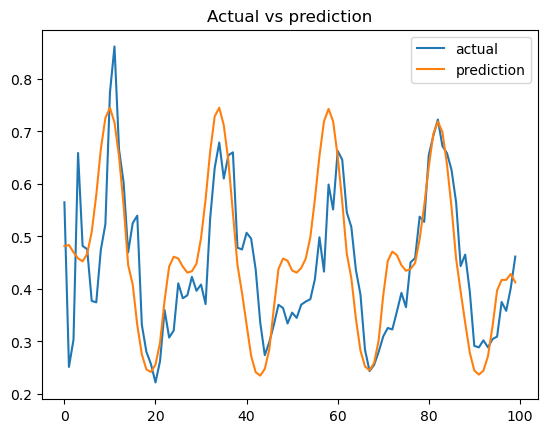

In [137]:
train_performance_visualization(model6, x_train, y_train, 0, 100)

# Run 7

In [13]:
def model_builder(hp):
    model = Sequential()
    
    # Tune the number of units in the first LSTM layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units_2, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units_3))
    model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [14]:
tuner7=kt.Hyperband(model_builder,
                   objective = 'val_mean_absolute_error', 
                   max_epochs = 50, 
                   factor= 3)

Reloading Tuner from .\untitled_project\tuner0.json


In [17]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_7/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
    

In [19]:
tuner7.search(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
# Get the optimal hyperparameters
best_hps=tuner7.get_best_hyperparameters(num_trials=1)[0]


Trial 90 Complete [00h 02m 45s]
val_mean_absolute_error: 0.037627171725034714

Best val_mean_absolute_error So Far: 0.03400808200240135
Total elapsed time: 22h 46m 23s


In [20]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is {best_hps.get('units')}, second LSTM layer is {best_hps.get('units_2')}, third LSTM layer is {best_hps.get('units_3')},
and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is 128, second LSTM layer is 224, third LSTM layer is 352,
and the optimal learning rate for the optimizer
is 0.001.



Epoch 1/500
497/497 [==============================] - 6s 7ms/step - loss: 0.0704 - mean_absolute_error: 0.0704 - val_loss: 0.0649 - val_mean_absolute_error: 0.0649
Epoch 2/500
497/497 [==============================] - 3s 5ms/step - loss: 0.0574 - mean_absolute_error: 0.0574 - val_loss: 0.0733 - val_mean_absolute_error: 0.0733
Epoch 3/500
497/497 [==============================] - 3s 5ms/step - loss: 0.0548 - mean_absolute_error: 0.0548 - val_loss: 0.0646 - val_mean_absolute_error: 0.0646
Epoch 4/500
497/497 [==============================] - 3s 5ms/step - loss: 0.0508 - mean_absolute_error: 0.0508 - val_loss: 0.0532 - val_mean_absolute_error: 0.0532
Epoch 5/500
497/497 [==============================] - 2s 5ms/step - loss: 0.0437 - mean_absolute_error: 0.0437 - val_loss: 0.0572 - val_mean_absolute_error: 0.0572
Epoch 6/500
497/497 [==============================] - 2s 5ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0394 - val_mean_absolute_error: 0.0394
Epoch 7/50

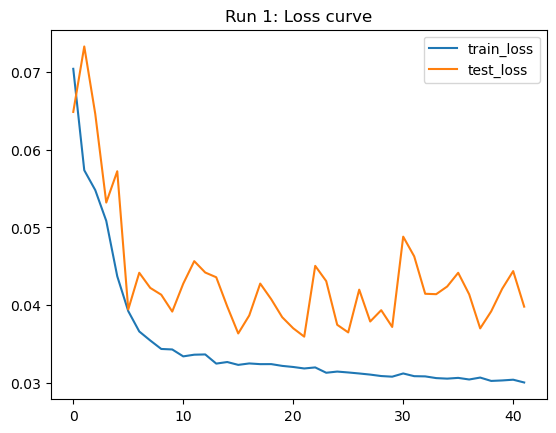

In [21]:
model7 = tuner7.hypermodel.build(best_hps)
history = model7.fit(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Run 1: Loss curve")
plt.legend()
plt.show()

125/125 [==============================] - 1s 2ms/step
MAE: 0.03981066156856569
MAPE: 0.09674317235550817
RMSE: 0.052885987886037


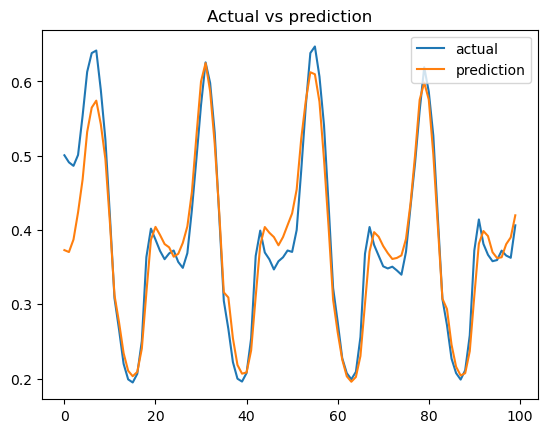

In [22]:
train_performance_visualization(model7, x_test, y_test, 0, 100)

497/497 [==============================] - 1s 1ms/step
MAE: 0.02886924356139274
MAPE: 0.06623387204169813
RMSE: 0.04194104183550432


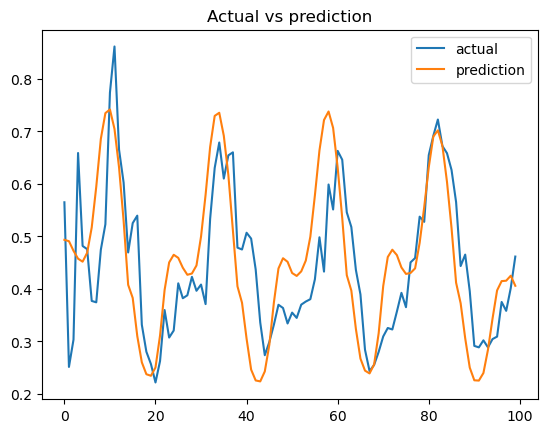

In [23]:
train_performance_visualization(model7, x_train, y_train, 0, 100)

# Run 8 CNN-LSTM

In [39]:
x_test.shape

(3973, 1, 6)

In [40]:
x_train_2 = x_train.reshape((x_train.shape[0], x_train.shape[2], 1))
x_test_2 = x_test.reshape((x_test.shape[0], x_test.shape[2], 1))
print(x_train_2.shape, y_train.shape, x_test_2.shape, y_test.shape)

(15889, 6, 1) (15889, 1) (3973, 6, 1) (3973, 1)


In [47]:
def get_model_cnn_lstm():
    model = Sequential()
    model.add(tf.keras.Input(shape=(x_train_2.shape[1], x_train_2.shape[2])))
    model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=5, activation='relu'))
    model.add(LSTM(6, return_sequences=True, activation='relu'))
    model.add(LSTM(6, return_sequences=False, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])
    return model

model8 = get_model_cnn_lstm()
model8.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 2, 6)              36        
                                                                 
 lstm_14 (LSTM)              (None, 2, 6)              312       
                                                                 
 lstm_15 (LSTM)              (None, 6)                 312       
                                                                 
 dense_6 (Dense)             (None, 1)                 7         
                                                                 
Total params: 667 (2.61 KB)
Trainable params: 667 (2.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/500
221/221 - 2s - loss: 0.2237 - mean_absolute_error: 0.2237 - val_loss: 0.1725 - val_mean_absolute_error: 0.1725 - 2s/epoch - 9ms/step
Epoch 2/500
221/221 - 0s - loss: 0.1134 - mean_absolute_error: 0.1134 - val_loss: 0.1409 - val_mean_absolute_error: 0.1409 - 415ms/epoch - 2ms/step
Epoch 3/500
221/221 - 0s - loss: 0.0934 - mean_absolute_error: 0.0934 - val_loss: 0.1169 - val_mean_absolute_error: 0.1169 - 405ms/epoch - 2ms/step
Epoch 4/500
221/221 - 0s - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.1054 - val_mean_absolute_error: 0.1054 - 403ms/epoch - 2ms/step
Epoch 5/500
221/221 - 0s - loss: 0.0805 - mean_absolute_error: 0.0805 - val_loss: 0.1028 - val_mean_absolute_error: 0.1028 - 417ms/epoch - 2ms/step
Epoch 6/500
221/221 - 0s - loss: 0.0794 - mean_absolute_error: 0.0794 - val_loss: 0.1030 - val_mean_absolute_error: 0.1030 - 380ms/epoch - 2ms/step
Epoch 7/500
221/221 - 0s - loss: 0.0790 - mean_absolute_error: 0.0790 - val_loss: 0.1027 - val_mean_absolute_error:

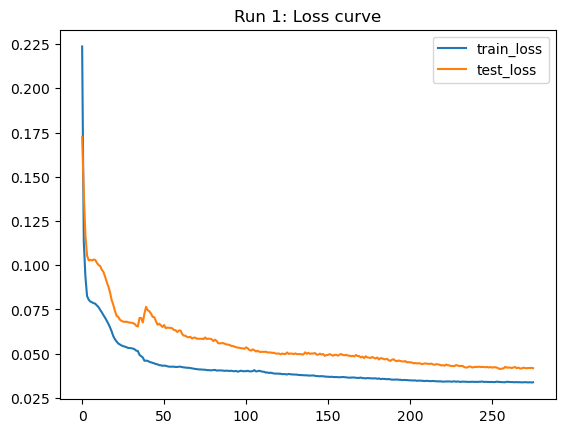

In [48]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/run_8/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.2f}-val_MAE-{val_mean_absolute_error:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
]
# fit network
history = model8.fit(x_train_2, y_train, validation_data = (x_test_2, y_test), epochs=500, batch_size=72, callbacks=callbacks_list, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Run 1: Loss curve")
plt.legend()
plt.show()

497/497 [==============================] - 1s 949us/step
MAE: 0.037946552532499116
MAPE: 0.08390429460429838
RMSE: 0.052319374915669375


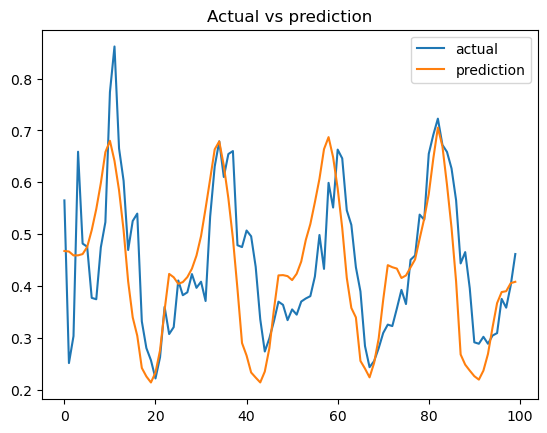

In [50]:
train_performance_visualization(model8, x_train_2, y_train, 0, 100)

125/125 [==============================] - 0s 1ms/step
MAE: 0.04174752169402582
MAPE: 0.09497740764579429
RMSE: 0.05342621282273601


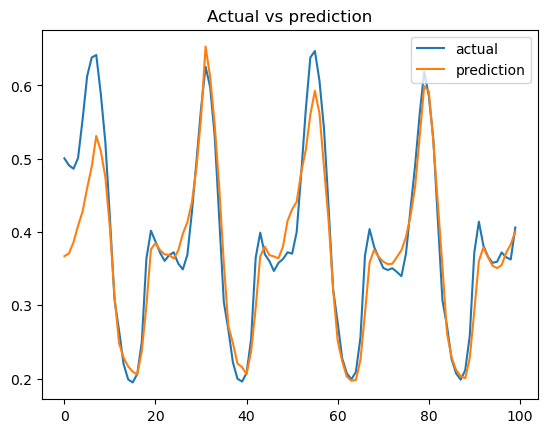

In [51]:
train_performance_visualization(model8, x_test_2, y_test, 0, 100)

# Run 9 

In [7]:
def model_builder(hp):
    model = Sequential()
    model.add(tf.keras.Input(shape=(x_train_2.shape[1], x_train_2.shape[2])))
    
    hp_kernel = hp.Int('kernel_size', min_value=1, max_value=5, step=1)
    model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=hp_kernel, activation='relu'))
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units, return_sequences=True, activation='relu'))
    
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    model.add(LSTM(units=hp_units_2, return_sequences=False, activation='relu'))
    
    model.add(Dense(1))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [8]:
x_train_2 = x_train.reshape((x_train.shape[0], x_train.shape[2], 1))
x_test_2 = x_test.reshape((x_test.shape[0], x_test.shape[2], 1))
print(x_train_2.shape, y_train.shape, x_test_2.shape, y_test.shape)

(15889, 6, 1) (15889, 1) (3973, 6, 1) (3973, 1)


In [9]:
tuner8=kt.Hyperband(model_builder,
                   objective = 'val_mean_absolute_error', 
                   max_epochs = 50, 
                   factor= 3)

In [10]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_9/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.3f}-val_MAE-{val_mean_absolute_error:4.3f}-loss-{val_loss:4.3f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
    

In [11]:
tuner8.search(x_train_2, y_train, epochs=500, validation_data = (x_test_2, y_test), callbacks=callbacks_list)
# Get the optimal hyperparameters
best_hps=tuner8.get_best_hyperparameters(num_trials=1)[0]


Trial 90 Complete [00h 05m 22s]
val_mean_absolute_error: 0.03518465533852577

Best val_mean_absolute_error So Far: 0.032572709023952484
Total elapsed time: 01h 23m 12s


In [14]:
print(f"""
The hyperparameter search is complete. The optimal kernel size is {best_hps.get("kernel_size")}. 
The optimal number of units in the first LSTM layer is {best_hps.get('units')}, 
second LSTM layer is {best_hps.get('units_2')}, 
and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal kernel size is 1. 
The optimal number of units in the first LSTM layer is 160, 
second LSTM layer is 512, 
and the optimal learning rate for the optimizer
is 0.0001.



Epoch 1/500
497/497 [==============================] - 10s 16ms/step - loss: 0.0892 - mean_absolute_error: 0.0892 - val_loss: 0.0747 - val_mean_absolute_error: 0.0747
Epoch 2/500
497/497 [==============================] - 8s 16ms/step - loss: 0.0628 - mean_absolute_error: 0.0628 - val_loss: 0.0689 - val_mean_absolute_error: 0.0689
Epoch 3/500
497/497 [==============================] - 8s 16ms/step - loss: 0.0535 - mean_absolute_error: 0.0535 - val_loss: 0.0570 - val_mean_absolute_error: 0.0570
Epoch 4/500
497/497 [==============================] - 8s 16ms/step - loss: 0.0479 - mean_absolute_error: 0.0479 - val_loss: 0.0541 - val_mean_absolute_error: 0.0541
Epoch 5/500
497/497 [==============================] - 8s 16ms/step - loss: 0.0438 - mean_absolute_error: 0.0438 - val_loss: 0.0542 - val_mean_absolute_error: 0.0542
Epoch 6/500
497/497 [==============================] - 8s 16ms/step - loss: 0.0409 - mean_absolute_error: 0.0409 - val_loss: 0.0449 - val_mean_absolute_error: 0.0449
Epo

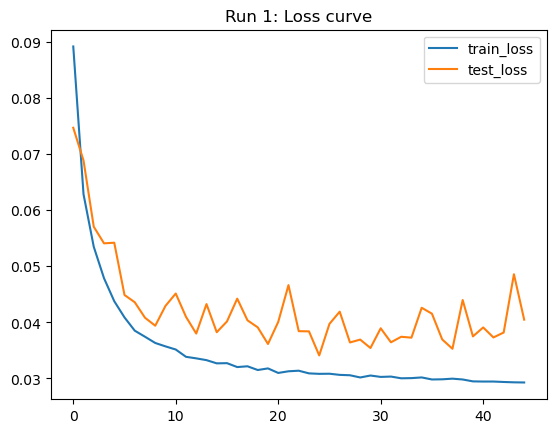

In [17]:
model9 = tuner8.hypermodel.build(best_hps)
history = model9.fit(x_train_2, y_train, epochs=500, validation_data = (x_test_2, y_test), callbacks=callbacks_list)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Run 1: Loss curve")
plt.legend()
plt.show()

125/125 [==============================] - 1s 5ms/step
MAE: 0.04047988214944121
MAPE: 0.10274540658191926
RMSE: 0.050661058068777555


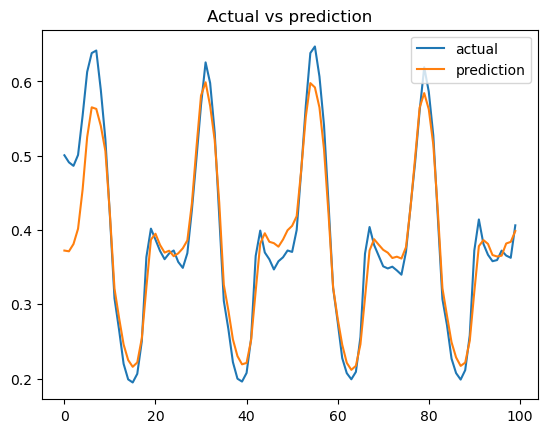

In [19]:
train_performance_visualization(model9, x_test_2, y_test, 0, 100)

497/497 [==============================] - 2s 5ms/step
MAE: 0.028975632372499224
MAPE: 0.06957555750359382
RMSE: 0.04136535431560548


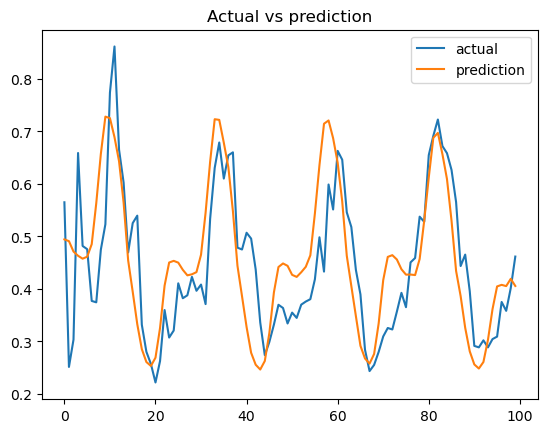

In [20]:
train_performance_visualization(model9, x_train_2, y_train, 0, 100)

# Dataset window approach

In [32]:
from pandas import concat
from pandas import DataFrame

In [33]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0 , -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
     # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
    return agg


In [34]:
dataset_window = series_to_supervised(y_train, 1, 1)

In [35]:
dataset_window

,var1(t-1),var1(t)
1,0.565000,0.251333
2,0.251333,0.303286
3,0.303286,0.658900
4,0.658900,0.481769
5,0.481769,0.475692
...,...,...
15886,0.266919,0.329505
15887,0.329505,0.406814
15888,0.406814,0.439729
15889,0.439729,0.436455


Epoch 1/500
221/221 - 1s - loss: 0.1593 - mean_absolute_error: 0.1593 - val_loss: 0.0990 - val_mean_absolute_error: 0.0990 - 562ms/epoch - 3ms/step
Epoch 2/500
221/221 - 0s - loss: 0.0857 - mean_absolute_error: 0.0857 - val_loss: 0.0951 - val_mean_absolute_error: 0.0951 - 180ms/epoch - 815us/step
Epoch 3/500
221/221 - 0s - loss: 0.0837 - mean_absolute_error: 0.0837 - val_loss: 0.0969 - val_mean_absolute_error: 0.0969 - 171ms/epoch - 772us/step
Epoch 4/500
221/221 - 0s - loss: 0.0844 - mean_absolute_error: 0.0844 - val_loss: 0.0886 - val_mean_absolute_error: 0.0886 - 190ms/epoch - 858us/step
Epoch 5/500
221/221 - 0s - loss: 0.0803 - mean_absolute_error: 0.0803 - val_loss: 0.0897 - val_mean_absolute_error: 0.0897 - 182ms/epoch - 824us/step
Epoch 6/500
221/221 - 0s - loss: 0.0813 - mean_absolute_error: 0.0813 - val_loss: 0.0942 - val_mean_absolute_error: 0.0942 - 169ms/epoch - 766us/step
Epoch 7/500
221/221 - 0s - loss: 0.0811 - mean_absolute_error: 0.0811 - val_loss: 0.0949 - val_mean_ab

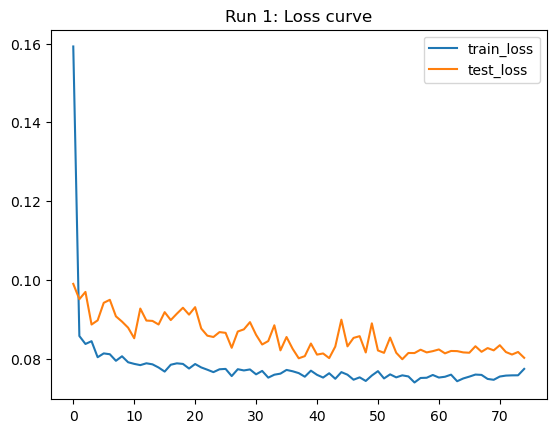

In [151]:
# design network
model = Sequential()
model.add(Dense(50, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/run_1/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.2f}-val_MAE-{val_mean_absolute_error:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
]
# fit network
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=500, batch_size=72, callbacks=callbacks_list, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Run 1: Loss curve")
plt.legend()
plt.show()